<a href="https://colab.research.google.com/github/PALLADIUM26/EnhanceIt/blob/main/image_dual_lime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
from scipy.spatial import distance
from scipy.ndimage.filters import convolve
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve
import argparse
from argparse import RawTextHelpFormatter
import glob
from os import makedirs
from os.path import join, exists, basename, splitext
import os
from tqdm import tqdm

<ipython-input-1-78f57e0177df>:4: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve


In [ ]:
#utils
def get_sparse_neighbor(p: int, n: int, m: int):
    i, j = p // m, p % m
    d = {}
    if i - 1 >= 0:
        d[(i - 1) * m + j] = (i - 1, j, 0)
    if i + 1 < n:
        d[(i + 1) * m + j] = (i + 1, j, 0)
    if j - 1 >= 0:
        d[i * m + j - 1] = (i, j - 1, 1)
    if j + 1 < m:
        d[i * m + j + 1] = (i, j + 1, 1)
    return d

In [ ]:
def create_spacial_affinity_kernel(spatial_sigma: float, size: int = 15):
    kernel = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            kernel[i, j] = np.exp(-0.5 * (distance.euclidean((i, j), (size // 2, size // 2)) ** 2) / (spatial_sigma ** 2))

    return kernel

In [ ]:
def compute_smoothness_weights(L: np.ndarray, x: int, kernel: np.ndarray, eps: float = 1e-3):
    Lp = cv2.Sobel(L, cv2.CV_64F, int(x == 1), int(x == 0), ksize=1)
    T = convolve(np.ones_like(L), kernel, mode='constant')
    T = T / (np.abs(convolve(Lp, kernel, mode='constant')) + eps)
    return T / (np.abs(Lp) + eps)

In [ ]:
def fuse_multi_exposure_images(im: np.ndarray, under_ex: np.ndarray, over_ex: np.ndarray,
                               bc: float = 1, bs: float = 1, be: float = 1):
    merge_mertens = cv2.createMergeMertens(bc, bs, be)
    images = [np.clip(x * 255, 0, 255).astype("uint8") for x in [im, under_ex, over_ex]]
    fused_images = merge_mertens.process(images)
    return fused_images

In [ ]:
def refine_illumination_map_linear(L: np.ndarray, gamma: float, lambda_: float, kernel: np.ndarray, eps: float = 1e-3):
    # compute smoothness weights
    wx = compute_smoothness_weights(L, x=1, kernel=kernel, eps=eps)
    wy = compute_smoothness_weights(L, x=0, kernel=kernel, eps=eps)

    n, m = L.shape
    L_1d = L.copy().flatten()

    # compute the five-point spatially inhomogeneous Laplacian matrix
    row, column, data = [], [], []
    for p in range(n * m):
        diag = 0
        for q, (k, l, x) in get_sparse_neighbor(p, n, m).items():
            weight = wx[k, l] if x else wy[k, l]
            row.append(p)
            column.append(q)
            data.append(-weight)
            diag += weight
        row.append(p)
        column.append(p)
        data.append(diag)
    F = csr_matrix((data, (row, column)), shape=(n * m, n * m))

    # solve the linear system
    Id = diags([np.ones(n * m)], [0])
    A = Id + lambda_ * F
    L_refined = spsolve(csr_matrix(A), L_1d, permc_spec=None, use_umfpack=True).reshape((n, m))

    # gamma correction
    L_refined = np.clip(L_refined, eps, 1) ** gamma

    return L_refined


In [ ]:
def correct_underexposure(im: np.ndarray, gamma: float, lambda_: float, kernel: np.ndarray, eps: float = 1e-3):
    # first estimation of the illumination map
    L = np.max(im, axis=-1)
    # illumination refinement
    L_refined = refine_illumination_map_linear(L, gamma, lambda_, kernel, eps)

    # correct image underexposure
    L_refined_3d = np.repeat(L_refined[..., None], 3, axis=-1)
    im_corrected = im / L_refined_3d
    return im_corrected

In [ ]:
def enhance_image_exposure(im: np.ndarray, gamma: float, lambda_: float, dual: bool = True, sigma: int = 3,
                           bc: float = 1, bs: float = 1, be: float = 1, eps: float = 1e-3):
    # create spacial affinity kernel
    kernel = create_spacial_affinity_kernel(sigma)

    # correct underexposudness
    im_normalized = im.astype(float) / 255.
    under_corrected = correct_underexposure(im_normalized, gamma, lambda_, kernel, eps)

    if dual:
        # correct overexposure and merge if DUAL method is selected
        inv_im_normalized = 1 - im_normalized
        over_corrected = 1 - correct_underexposure(inv_im_normalized, gamma, lambda_, kernel, eps)
        # fuse images
        im_corrected = fuse_multi_exposure_images(im_normalized, under_corrected, over_corrected, bc, bs, be)
    else:
        im_corrected = under_corrected

    # convert to 8 bits and returns
    return np.clip(im_corrected * 255, 0, 255).astype("uint8")

In [ ]:
# def main(args):
#     # load images
#     imdir = args.folder
#     ext = ['png', 'jpg', 'bmp']    # Add image formats here
#     files = []
#     [files.extend(glob.glob(imdir + '*.' + e)) for e in ext]
#     images = [cv2.imread(file) for file in files]

#     # create save directory
#     directory = join(imdir, "enhanced")
#     if not exists(directory):
#         makedirs(directory)

def main():
    # load images
    # imdir = args.folder
    # imdir = "demo"
    # if not os.path.isdir(imdir):
    #     print(f"Error: '{imdir}' is not a valid directory.")
    #     return  # Exit the function if the provided path is not a directory

    # ext = ['png', 'jpg', 'bmp']    # Add image formats here
    # files = []
    # [files.extend(glob.glob(imdir + '*.' + e)) for e in ext]
    # images = [cv2.imread(file) for file in files]

    image = cv2.imread("/content/demo.jpg")

    # create save directory
    directory = join("imdir", "enhanced")
    if not exists(directory):
        makedirs(directory)

    # enhance images
    # for i, image in tqdm(enumerate(images), desc="Enhancing images"):
        # enhanced_image = enhance_image_exposure(image, args.gamma, args.lambda_, not args.lime,
        #                                         sigma=args.sigma, bc=args.bc, bs=args.bs, be=args.be, eps=args.eps)

    filename = basename("demo.jpg")
    name, ext = splitext(filename)

    enhanced_image = enhance_image_exposure(image, 0.6, 0.15, "LIME", sigma=3, bc=1, bs=1, be=1, eps=1e-3)
    method = "LIME"
    corrected_name = f"{name}_{method}_g{0.6}_l{0.15}{ext}"
    cv2.imwrite(join(directory, corrected_name), enhanced_image)

    enhanced_image2 = enhance_image_exposure(image, 0.6, 0.15, not "LIME", sigma=3, bc=1, bs=1, be=1, eps=1e-3)
    method2 = "DUAL"
    corrected_name2 = f"{name}_{method2}_g{0.6}_l{0.15}{ext}"
    cv2.imwrite(join(directory, corrected_name2), enhanced_image2)

main()

In [ ]:
import matplotlib.pyplot as plt

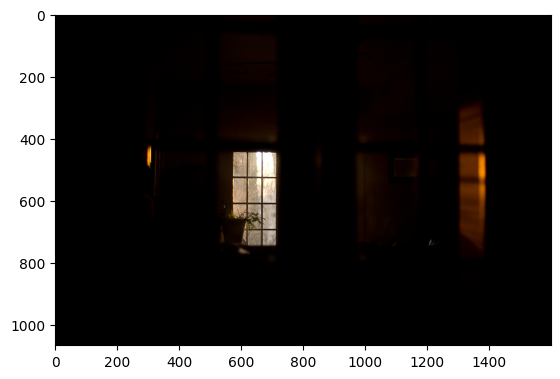

In [ ]:
# ORIGINAL IMAGE
img_color = cv2.imread("/content/demo.jpg",1)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))

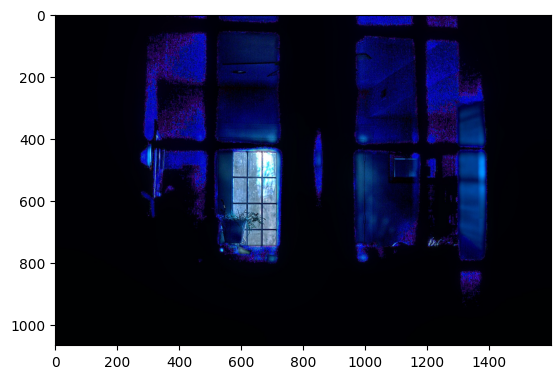

In [ ]:
img_color = cv2.imread("/content/imdir/enhanced/demo_LIME_g0.6_l0.15.jpg",1)
plt.imshow(img_color)

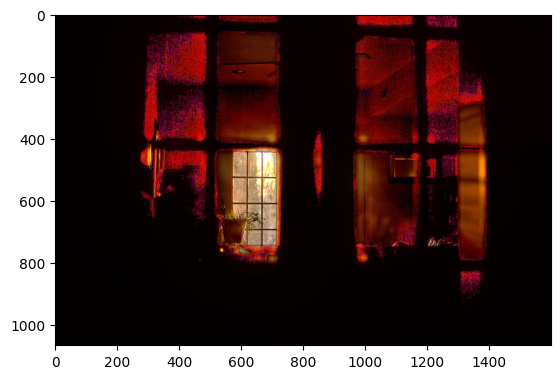

In [ ]:
# LIGHTEN UP IMAGE USING LIME
img_color = cv2.imread("/content/imdir/enhanced/demo_LIME_g0.6_l0.15.jpg",1)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))

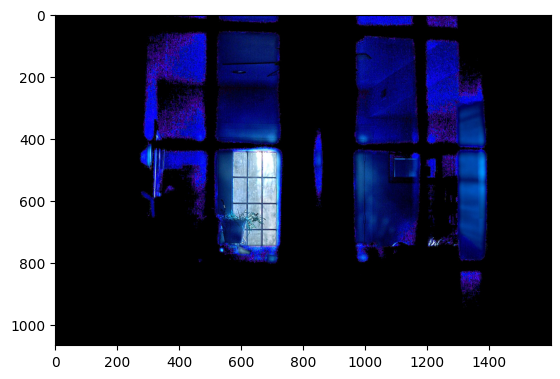

In [ ]:
img_color = cv2.imread("/content/imdir/enhanced/demo_DUAL_g0.6_l0.15.jpg",1)
plt.imshow(img_color)

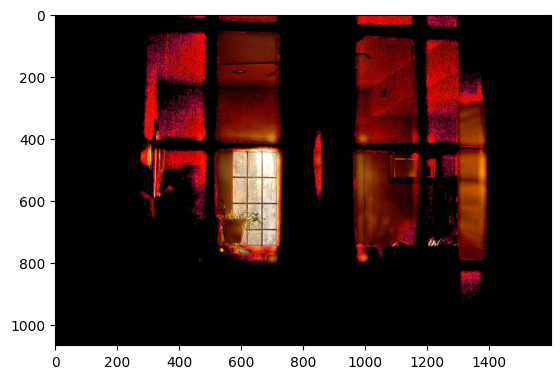

In [ ]:
# LIGHTEN UP IMAGE USING DUAL
img_color = cv2.imread("/content/imdir/enhanced/demo_DUAL_g0.6_l0.15.jpg",1)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))

In [ ]:
# if __name__ == "__main__":
#     parser = argparse.ArgumentParser(
#         description="Python implementation of two low-light image enhancement techniques via illumination map estimation.",
#         formatter_class=RawTextHelpFormatter
#     )
#     parser.add_argument("-f", '--folder', default='./demo/', type=str,
#                         help="folder path to test images.")
#     parser.add_argument("-g", '--gamma', default=0.6, type=float,
#                         help="the gamma correction parameter.")
#     parser.add_argument("-l", '--lambda_', default=0.15, type=float,
#                         help="the weight for balancing the two terms in the illumination refinement optimization objective.")
#     parser.add_argument("-ul", "--lime", action='store_true',
#                         help="Use the LIME method. By default, the DUAL method is used.")
#     parser.add_argument("-s", '--sigma', default=3, type=int,
#                         help="Spatial standard deviation for spatial affinity based Gaussian weights.")
#     parser.add_argument("-bc", default=1, type=float,
#                         help="parameter for controlling the influence of Mertens's contrast measure.")
#     parser.add_argument("-bs", default=1, type=float,
#                         help="parameter for controlling the influence of Mertens's saturation measure.")
#     parser.add_argument("-be", default=1, type=float,
#                         help="parameter for controlling the influence of Mertens's well exposedness measure.")
#     parser.add_argument("-eps", default=1e-3, type=float,
#                         help="constant to avoid computation instability.")

#     args = parser.parse_args()
#     main(args)